In [ ]:
import kagglehub
import os
import glob

dataset_path = kagglehub.dataset_download("awsaf49/coco-2017-dataset")
print("Path to dataset files:", dataset_path)

In [151]:
import os
import json
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# SETUP & DATA PREPARATION

In [152]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = 256
NUM_KEYPOINTS = 17    
BATCH_SIZE = 32
INITIAL_EPOCHS = 10   
FINETUNE_EPOCHS = 5  

In [153]:
tensorflow_dataset_path = "/kaggle/input/coco-2017-dataset/coco2017"
TRAIN_DIR = os.path.join(tensorflow_dataset_path, "train2017")
ANNOTATION_PATH = os.path.join(tensorflow_dataset_path, "annotations", "person_keypoints_train2017.json")

In [154]:
with open(ANNOTATION_PATH, 'r') as f:
    coco = json.load(f)

annotation_dict = {}
for ann in coco['annotations']:
    if ann['num_keypoints'] < NUM_KEYPOINTS:
        continue
    img_info = next((img for img in coco['images'] if img['id'] == ann['image_id']), None)
    if img_info is None:
        continue
    file_name = img_info['file_name']
    keypoints = np.array(ann['keypoints'], dtype=np.float32).reshape(NUM_KEYPOINTS, 3)
    w, h = img_info['width'], img_info['height']
    xy = keypoints[:, :2]
    xy[:, 0] /= w
    xy[:, 1] /= h
    annotation_dict[file_name] = xy.flatten()

In [155]:
samples = []
for fname, kp in annotation_dict.items():
    img_path = os.path.join(TRAIN_DIR, fname)
    if os.path.exists(img_path):
        samples.append((img_path, kp))
    if len(samples) >= 2000:
        break

random.shuffle(samples)
split_idx = int(0.8 * len(samples))
train_samples = samples[:split_idx]
val_samples = samples[split_idx:]


# DATA LOADING, PREPROCESSING & AUGMENTATION

In [156]:
def load_and_preprocess(path):
    if isinstance(path, tf.Tensor):
        path = path.numpy().decode("utf-8")
    elif isinstance(path, (bytes, np.bytes_)):
        path = path.decode("utf-8")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
    img = img.astype(np.float32) / 255.0
    return img

@tf.function
def tf_preprocess(path, keypoints):
    img = tf.py_function(func=load_and_preprocess, inp=[path], Tout=tf.float32)
    img.set_shape((IMAGE_SIZE, IMAGE_SIZE, 3))
    return img, keypoints

In [157]:
def augment_image(img, keypoints):
    if tf.random.uniform([]) > 0.5:
        img = tf.image.flip_left_right(img)
        kp = tf.reshape(keypoints, (NUM_KEYPOINTS, 2))
        kp_x, kp_y = kp[:, 0], kp[:, 1]
        kp_x = 1.0 - kp_x 
        kp = tf.stack([kp_x, kp_y], axis=1)
        keypoints = tf.reshape(kp, (-1,))

    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)
    return img, keypoints

def create_dataset(samples, batch_size=BATCH_SIZE, augment=False):
    paths = [s[0] for s in samples]
    kps = np.array([s[1] for s in samples], dtype=np.float32)
    ds = tf.data.Dataset.from_tensor_slices((paths, kps))
    ds = ds.map(tf_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(len(samples)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

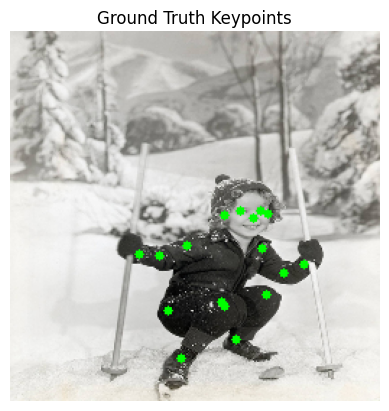

In [158]:
train_ds = create_dataset(train_samples, augment=True)
val_ds = create_dataset(val_samples, augment=False)

def show_keypoints(img, keypoints, title="Keypoints"):
    img_disp = (img * 255).astype(np.uint8).copy()
    for i in range(NUM_KEYPOINTS):
        x = int(keypoints[2 * i] * IMAGE_SIZE)
        y = int(keypoints[2 * i + 1] * IMAGE_SIZE)
        cv2.circle(img_disp, (x, y), 3, (0, 255, 0), -1)
    plt.figure()
    plt.imshow(img_disp)
    plt.title(title)
    plt.axis("off")
    plt.show()

sample_path, true_kp = random.choice(train_samples)
img_sample = load_and_preprocess(sample_path)
show_keypoints(img_sample, true_kp, title="Ground Truth Keypoints")

# MODEL DEFINITION WITH ITERATIVE REFINEMENT

In [162]:
backbone_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
backbone_model.trainable = False 

<ipython-input-162-d8508504c5fd>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  backbone_model = tf.keras.applications.MobileNetV2(


In [160]:
def build_refinement_block(feature_tensor, initial_preds):
    x = layers.GlobalAveragePooling2D()(feature_tensor)
    x = layers.concatenate([x, initial_preds])
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    refined_correction = layers.Dense(NUM_KEYPOINTS * 2, activation="tanh")(x)
    return refined_correction

In [161]:
def build_model_with_refinement(backbone):
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    x = backbone(inputs)
    x = layers.Conv2D(256, 3, padding="same", activation="relu", name="conv_head_1")(x)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(2, 2), name="upsample_1")(x)
    
    x = layers.Conv2D(128, 3, padding="same", activation="relu", name="conv_head_2")(x)
    x = layers.BatchNormalization()(x)
    feature_branch = layers.UpSampling2D(size=(2, 2), name="upsample_2")(x)
    
    x = layers.Conv2D(64, 3, padding="same", activation="relu", name="conv_head_3")(feature_branch)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D(size=(2, 2), name="upsample_3")(x)
    x_gap = layers.GlobalAveragePooling2D(name="global_avg_pool")(x)
    x_fc = layers.Dense(512, activation="relu", name="fc_1")(x_gap)
    x_fc = layers.Dropout(0.3)(x_fc)
    initial_preds = layers.Dense(NUM_KEYPOINTS * 2, activation="sigmoid", name="initial_preds")(x_fc)
    refined_correction = build_refinement_block(feature_branch, initial_preds)
    added = layers.Add(name="add_corrections")([initial_preds, refined_correction])
    final_preds = layers.Activation("sigmoid", name="final_preds")(added)
    
    return models.Model(inputs, final_preds, name="BlazePose_IterativeRefinement")


model = build_model_with_refinement(backbone_model)


model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=["mae"])
model.summary()

Model: "BlazePose_IterativeRefinement"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ mobilenetv2_1.00_224      │ (None, 8, 8, 1280)     │      2,257,984 │ input_image[0][0]      │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_head_1 (Conv2D)      │ (None, 8, 8, 256)      │      2,949,376 │ mobilenetv2_1.00_224[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 8, 8, 256)      │          1,024 │ conv_head_1[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_1 (UpSampling2D) │ (None, 16, 16, 256)    │              0 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_head_2 (Conv2D)      │ (None, 16, 16, 128)    │        295,040 │ upsample_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 16, 16, 128)    │            512 │ conv_head_2[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_2 (UpSampling2D) │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_head_3 (Conv2D)      │ (None, 32, 32, 64)     │         73,792 │ upsample_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 32, 64)     │            256 │ conv_head_3[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ upsample_3 (UpSampling2D) │ (None, 64, 64, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_avg_pool           │ (None, 64)             │              0 │ upsample_3[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ fc_1 (Dense)              │ (None, 512)            │         33,280 │ global_avg_pool[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_6 (Dropout)       │ (None, 512)            │              0 │ fc_1[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ initial_preds (Dense)     │ (None, 34)             │         17,442 │ dropout_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 128)            │              0 │ upsample_2[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3        

 Total params: 5,679,172 (21.66 MB)

 Trainable params: 3,420,292 (13.05 MB)

 Non-trainable params: 2,258,880 (8.62 MB)

# VISUALIZE INTERMEDIATE FEATURE MAPS

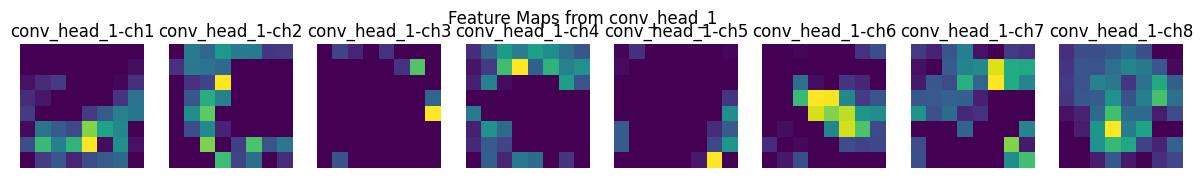

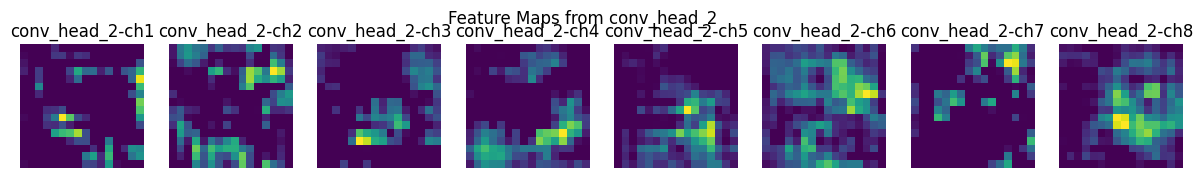

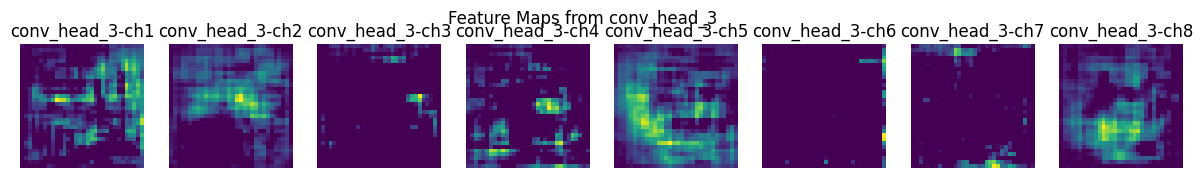

In [163]:
intermediate_layer_names = ["conv_head_1", "conv_head_2", "conv_head_3"]
intermediate_model = models.Model(
    inputs=model.input,
    outputs=[model.get_layer(name).output for name in intermediate_layer_names]
)

def visualize_feature_maps(image, model, layer_names):
    img_input = tf.expand_dims(image, 0)
    feature_maps = model(img_input)
    for fmap, lname in zip(feature_maps, layer_names):
        fmap = fmap[0].numpy()
        num_channels = fmap.shape[-1]
        n_channels_to_plot = min(8, num_channels)
        plt.figure(figsize=(15, 2))
        for i in range(n_channels_to_plot):
            plt.subplot(1, n_channels_to_plot, i+1)
            plt.imshow(fmap[..., i], cmap="viridis")
            plt.title(f"{lname}-ch{i+1}")
            plt.axis("off")
        plt.suptitle(f"Feature Maps from {lname}")
        plt.show()

visualize_feature_maps(img_sample, intermediate_model, intermediate_layer_names)

# TRAINING & FINE-TUNING

In [164]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-6
)

history = model.fit(train_ds, validation_data=val_ds, epochs=INITIAL_EPOCHS, callbacks=[lr_schedule])

for layer in backbone_model.layers[-20:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.Huber(),
              metrics=["mae"])

history_ft = model.fit(train_ds, validation_data=val_ds, epochs=FINETUNE_EPOCHS, callbacks=[lr_schedule])

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 182ms/step - loss: 0.0224 - mae: 0.1701 - val_loss: 0.0194 - val_mae: 0.1532 - learning_rate: 0.0010
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - loss: 0.0157 - mae: 0.1362 - val_loss: 0.0165 - val_mae: 0.1403 - learning_rate: 0.0010
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 91ms/step - loss: 0.0122 - mae: 0.1184 - val_loss: 0.0162 - val_mae: 0.1353 - learning_rate: 0.0010
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 95ms/step - loss: 0.0093 - mae: 0.1040 - val_loss: 0.0151 - val_mae: 0.1322 - learning_rate: 0.0010
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - loss: 0.0079 - mae: 0.0945 - val_loss: 0.0155 - val_mae: 0.1331 - learning_rate: 0.0010
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0064 - mae: 0.0846 - val_loss: 0.0147 - val_mae: 0.1287 - learning_rate: 0.0010
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 86ms/step - loss: 0.0058 - mae: 0.0809 - val_loss: 0.0144 - val_mae: 0.1268 - learning_rate: 0.0010
Epoch

# SAVE THE MODEL & PLOT TRAINING HISTORY

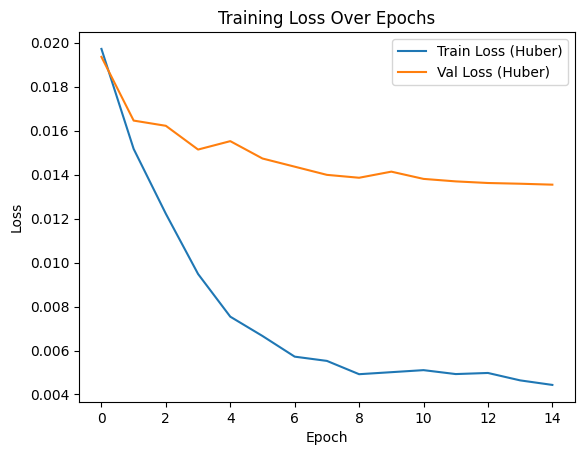

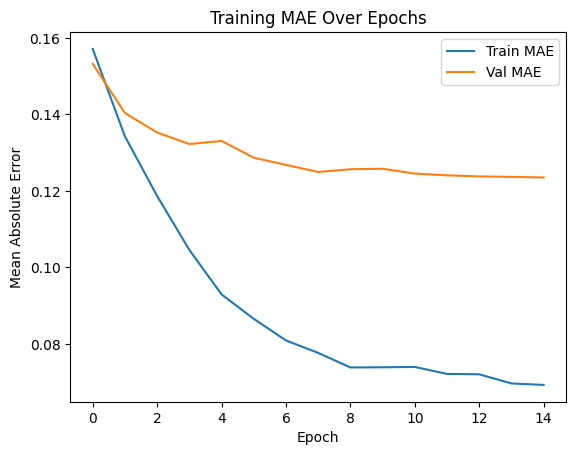

In [165]:
model.save("blazepose_coco_trained_refined.h5")

plt.figure()
loss_vals = history.history["loss"] + history_ft.history["loss"]
val_loss_vals = history.history["val_loss"] + history_ft.history["val_loss"]
plt.plot(loss_vals, label="Train Loss (Huber)")
plt.plot(val_loss_vals, label="Val Loss (Huber)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

plt.figure()
mae_vals = history.history["mae"] + history_ft.history["mae"]
val_mae_vals = history.history["val_mae"] + history_ft.history["val_mae"]
plt.plot(mae_vals, label="Train MAE")
plt.plot(val_mae_vals, label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.title("Training MAE Over Epochs")
plt.legend()
plt.show()

# INFERENCE & VISUALIZATION

In [ ]:
test_directory = "/kaggle/input/coco-2017-dataset/coco2017/test2017"  
test_samples = []
for fname in os.listdir(test_directory):
    img_path = os.path.join(test_directory, fname)
    if os.path.isfile(img_path):
        test_samples.append(img_path)

In [230]:
def show_keypoints_on_image(img, keypoints, title="Predicted Keypoints"):
    img_disp = (img * 255).astype(np.uint8).copy()
    print("Predicted keypoints shape:", keypoints.shape)
    for i in range(NUM_KEYPOINTS):
        x = int(keypoints[2 * i] * IMAGE_SIZE)
        y = int(keypoints[2 * i + 1] * IMAGE_SIZE)
        cv2.circle(img_disp, (x, y), 3, (0, 255, 0), -1)
    plt.figure()
    plt.imshow(img_disp)
    plt.title(title)
    plt.axis("off")
    plt.show()



Running prediction for: /kaggle/input/coco-2017-dataset/coco2017/test2017/000000039383.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted keypoints shape: (34,)


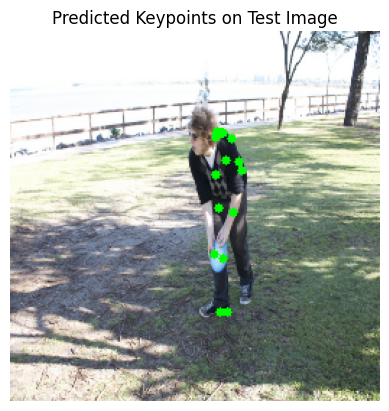

In [204]:
if len(test_samples) > 0:
    sample_test_path = random.choice(test_samples)
    print("Running prediction for:", sample_test_path)
    img_test = load_and_preprocess(sample_test_path)
    pred_keypoints = model.predict(tf.expand_dims(img_test, 0))[0]
    pred_keypoints = np.clip(pred_keypoints, 0, 1)
    show_keypoints_on_image(img_test, pred_keypoints, title="Predicted Keypoints on Test Image")
else:
    print("No test samples found. Please verify your test image directory path.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted keypoints shape: (34,)


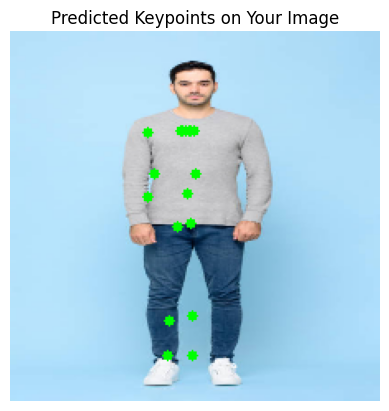

In [253]:
def predict_keypoints_on_image(image_path):
    img = load_and_preprocess(image_path)
    pred_keypoints = model.predict(tf.expand_dims(img, 0))[0]
    pred_keypoints = np.clip(pred_keypoints, 0, 1)
    show_keypoints_on_image(img, pred_keypoints, title="Predicted Keypoints on Your Image")

predict_keypoints_on_image("/kaggle/input/human-standing/DO/s4.jpg")
